# TVC Simulation for the NAVION-1 rocket
Uses NumPy & MatPlotLib as well as the Python Control Systems library and the RocketPy library.

In [131]:
import numpy as np
import matplotlib.pyplot as plt

import control

import rocketpy as rp

import datetime

In [132]:
# Rocket environment
env = rp.Environment(
    latitude=28,
    longitude=-81,
    elevation=5,
)

tomorrow = datetime.datetime.today() + datetime.timedelta(days=1)

env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))
env.set_atmospheric_model(type='Forecast', file='GFS')

Nozzle Details
Nozzle Radius: 0.006 m
Nozzle Throat Radius: 0.01 m

Grain Details
Number of Grains: 1
Grain Spacing: 0.0 m
Grain Density: 1700 kg/m3
Grain Outer Radius: 0.0135 m
Grain Inner Radius: 0.0035 m
Grain Height: 0.12 m
Grain Volume: 0.000 m3
Grain Mass: 0.109 kg

Motor Details
Total Burning Time: 12.601 s
Total Propellant Mass: 0.109 kg
Structural Mass Ratio: 0.384
Average Propellant Exhaust Velocity: 1338.653 m/s
Average Thrust: 11.574 N
Maximum Thrust: 31.2631 N at 0.502 s after ignition.
Total Impulse: 145.847 Ns



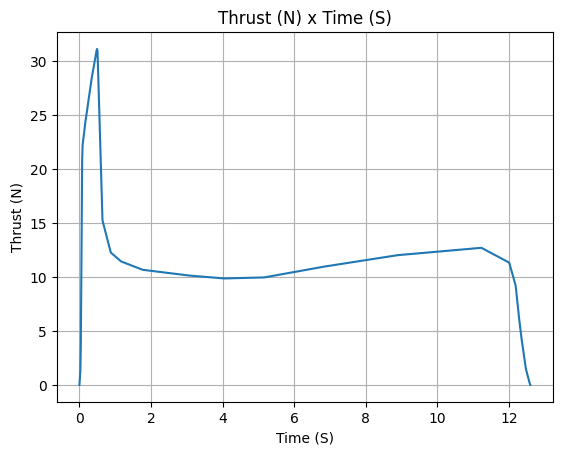

In [133]:
# Rocket motor
_motor_height = 0.156
_motor_wall_thickness = 0.002
_motor_outer_radius = 0.0145
_motor_inner_radius = _motor_outer_radius - _motor_wall_thickness
_motor_dry_mass = (150 - 82) / 1000

_ro2 = _motor_outer_radius ** 2
_ri2 = _motor_inner_radius ** 2

_Ixx = _Iyy = (1 / 12) * _motor_dry_mass * (3 * (_ro2 + _ri2) + _motor_height ** 2)
_Izz = (1 / 2) * _motor_dry_mass * (_ro2 + _ri2)

AeroTechG12STP = rp.SolidMotor(
    thrust_source='data/AeroTech_G12ST_clean.csv',
    dry_mass=_motor_dry_mass,
    dry_inertia=(_Ixx, _Iyy, _Izz),
    nozzle_radius=0.006,
    grain_number=1,
    grain_density=1700,
    grain_outer_radius=0.0135,
    grain_initial_inner_radius=0.0035,
    grain_initial_height=0.12,
    grain_separation=0.0,
    grains_center_of_mass_position=0.05,
    center_of_dry_mass_position=0.042
)

AeroTechG12STP.info()

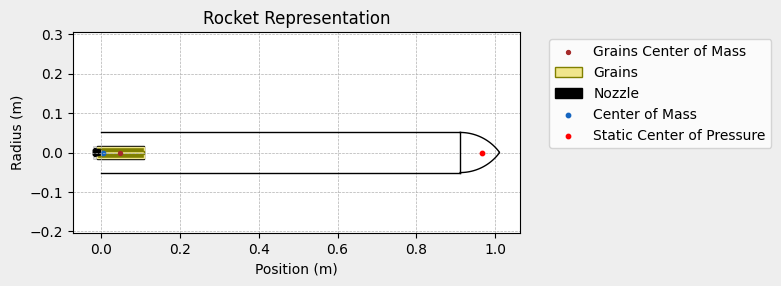

In [135]:
# Rocket
Ixx = Iyy = 0.11
Izz = 0.0015

navion1 = rp.Rocket(
    radius=0.0508,  # 2 inches
    mass=1.0,
    inertia=(Ixx, Iyy, Izz),
    power_off_drag=0.31,
    power_on_drag=0.23,
    center_of_mass_without_motor=0.0
)

navion1.add_motor(AeroTechG12STP, position=0.0)

nose_cone = navion1.add_nose(
    length=0.1,
    kind='ogive',
    bluffness=0.05,
    position=1.01,
)

main_parachute = navion1.add_parachute(
    name='main',
    cd_s=0.219,
    trigger='apogee',
)

navion1.draw()

In [151]:
# Rocket Controller
def tvc_controller(time, sampling_rate, state, state_history, observed_variables, interactive_objects, sensors):
    rocket = interactive_objects
    
    wx, wy, wz = state[11:14]
    
    Kp = 0.03
    torque = [-Kp * wx, -Kp * wy, -Kp * wz]
    
    rocket.torque = torque
    
    return torque

controller = rp._Controller(
    interactive_objects=navion1,
    controller_function=tvc_controller,
    sampling_rate=100,  # Hz
)

navion1._add_controllers(controller)

In [ ]:
# Flight simulation
flight = rp.Flight(
    rocket=navion1,
    environment=env,
    rail_length=0.001,
    inclination=90,
    heading=0
)

flight.plots.trajectory_3d()
flight.plots.linear_kinematics_data()
flight.plots.flight_path_angle_data()

TypeError: 'Rocket' object is not subscriptable

In [ ]:
Ix = 0.5  # Inertia about x-axis
Iy = 0.5  # Inertia about y-axis
Iz = 0.5  # Inertia about z-axis

dt = 0.01  # Time step

# State-space model
A = np.array([[0, 1],
              [0, 0]])
B = np.array([[0],
              [1 / Ix]])

C = np.eye(2)
D = np.zeros((2, 1))

sys = control.ss(A, B, C, D)

In [ ]:
# LQR cost matrices
Q = np.array([[1, 0],
              [0, 1]])
R = np.array([[0.01]])

K, S, E = control.lqr(sys, Q, R)

print("LQR Gain Matrix K:", K)

LQR Gain Matrix K: [[10.         10.48808848]]


In [ ]:
# Closed-loop system
A_cl = A - B @ K
sys_cl = control.ss(A_cl, B, C, D)

# Initial conditions
x0 = np.array([0.5, 0])

T = np.linspace(0, 10, int(10 / dt))
T, yout = control.initial_response(sys_cl, T=T, X0=x0)

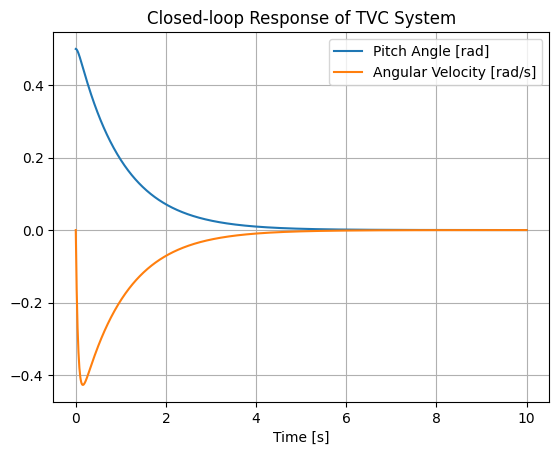

In [ ]:
# Plotting the response
plt.plot(T, yout[0], label='Pitch Angle [rad]')
plt.plot(T, yout[1], label='Angular Velocity [rad/s]')
plt.xlabel('Time [s]')
plt.legend()
plt.grid()
plt.title('Closed-loop Response of TVC System')
plt.show()